--- STEP 1: UPLOAD DATA ---
Please upload your 'Final.csv' file...


Saving Final.csv to Final (1).csv

Calculating Heating and Cooling Degree Days (Base 65°F)...
Analyzing years: [np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]

FINAL CONCLUSION REPORT

Model Parameters by Year:
|   Year |   Base Load (MW) |   Heating Sensitivity (MW/HDD) |   Cooling Sensitivity (MW/CDD) |   R2 Score |
|-------:|-----------------:|-------------------------------:|-------------------------------:|-----------:|
|   2020 |          2741.54 |                         28.518 |                         41.706 |      0.401 |
|   2021 |          2660.73 |                         31.219 |                         92.634 |      0.744 |
|   2022 |          2622.65 |                         34.867 |                         94.285 |      0.744 |
|   2023 |          2647.01 |                         28.818 |                         86.447 |      0.706 |
|   2024 |          2653.24 |                         30.379 |                        

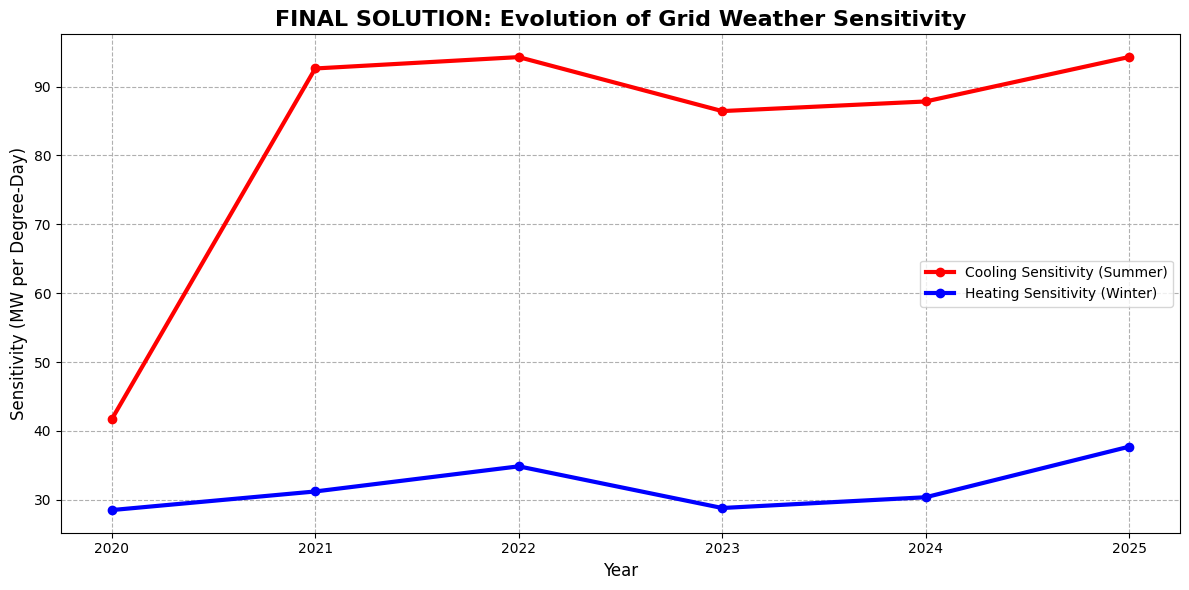

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import io
from google.colab import files

BASE_TEMP_F = 65.0

def main():
    print("--- STEP 1: UPLOAD DATA ---")
    print("Please upload your 'Final.csv' file...")
    uploaded = files.upload()
    filename = next(iter(uploaded))

    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
        df['Time_UTC'] = pd.to_datetime(df['Time_UTC'])
        df = df.set_index('Time_UTC').sort_index()

        df['mw'] = pd.to_numeric(df['mw'], errors='coerce')
        df['feel'] = pd.to_numeric(df['feel'], errors='coerce')
        df.dropna(subset=['mw', 'feel'], inplace=True)
        df['Year'] = df.index.year

    except Exception as e:
        print(f"Error: {e}")
        return

    print("\nCalculating Heating and Cooling Degree Days (Base 65°F)...")

    df['HDD'] = np.maximum(BASE_TEMP_F - df['feel'], 0)

    df['CDD'] = np.maximum(df['feel'] - BASE_TEMP_F, 0)

    results = []

    valid_years = sorted(df['Year'].unique())
    print(f"Analyzing years: {valid_years}")

    for year in valid_years:
        df_year = df[df['Year'] == year]

        if len(df_year) < 100:
            continue

        X = df_year[['HDD', 'CDD']]
        y = df_year['mw']

        model = LinearRegression()
        model.fit(X, y)

        base_load = model.intercept_
        heating_slope = model.coef_[0]
        cooling_slope = model.coef_[1]
        r2 = r2_score(y, model.predict(X))

        results.append({
            'Year': year,
            'Base Load (MW)': base_load,
            'Heating Sensitivity (MW/HDD)': heating_slope,
            'Cooling Sensitivity (MW/CDD)': cooling_slope,
            'R2 Score': r2
        })

    results_df = pd.DataFrame(results)

    print("\n" + "="*50)
    print("FINAL CONCLUSION REPORT")
    print("="*50)

    print("\nModel Parameters by Year:")
    print(results_df.round(3).to_markdown(index=False))

    first_year = results_df.iloc[0]
    last_year = results_df.iloc[-1]

    cool_change = ((last_year['Cooling Sensitivity (MW/CDD)'] - first_year['Cooling Sensitivity (MW/CDD)']) / first_year['Cooling Sensitivity (MW/CDD)']) * 100
    heat_change = ((last_year['Heating Sensitivity (MW/HDD)'] - first_year['Heating Sensitivity (MW/HDD)']) / first_year['Heating Sensitivity (MW/HDD)']) * 100
    base_change = ((last_year['Base Load (MW)'] - first_year['Base Load (MW)']) / first_year['Base Load (MW)']) * 100

    print(f"\n--- CHANGE ANALYSIS ({first_year['Year']} vs {last_year['Year']}) ---")
    print(f"1. COOLING SENSITIVITY (Summer Stress): {cool_change:+.2f}%")
    print(f"   (Did the grid work harder per degree of heat? {'YES (Worsening)' if cool_change > 0 else 'NO (Improving)'})")

    print(f"\n2. HEATING SENSITIVITY (Winter Stress): {heat_change:+.2f}%")
    print(f"   (Did the grid work harder per degree of cold? {'YES (Worsening)' if heat_change > 0 else 'NO (Improving)'})")

    print(f"\n3. BASE LOAD (Non-Weather Load):        {base_change:+.2f}%")
    print(f"   (General demand growth/decline independent of weather)")

    plt.figure(figsize=(12, 6))

    plt.plot(results_df['Year'], results_df['Cooling Sensitivity (MW/CDD)'],
             marker='o', color='red', linewidth=3, label='Cooling Sensitivity (Summer)')

    plt.plot(results_df['Year'], results_df['Heating Sensitivity (MW/HDD)'],
             marker='o', color='blue', linewidth=3, label='Heating Sensitivity (Winter)')

    plt.title('FINAL SOLUTION: Evolution of Grid Weather Sensitivity', fontsize=16, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Sensitivity (MW per Degree-Day)', fontsize=12)
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()